In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix, make_scorer
import cloudpickle
import dill
import os
import warnings

# settings
SESSION_FILE = "variables.session"
def save_session():
    dill.dump_session(SESSION_FILE)
    print(f"Session saved to {SESSION_FILE}")
def load_session():
    if os.path.exists(SESSION_FILE):
        dill.load_session(SESSION_FILE)
        print(f"Session loaded from {SESSION_FILE}")
    else:
        print("No saved session found.")
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)

In [3]:
# load everything
load_session()

Session loaded from variables.session


In [4]:
# load dataset
data = pd.read_csv("dataset.csv")
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [5]:
# data backup
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [6]:
# duplicates
df[df.duplicated()]

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target


In [7]:
# null values
df.isnull().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                                     0
Curricular u

In [8]:
# target variable distribution
df['Target'].value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

In [9]:
# removing data of enrolled students
df.drop(df[df['Target'] == "Enrolled"].index, inplace = True)
df['Target'].value_counts()

Target
Graduate    2209
Dropout     1421
Name: count, dtype: int64

In [10]:
# numeric and non numeric columns
non_numeric_columns = df.select_dtypes(include= ['object']).columns.to_list()
numeric_columns = df.select_dtypes(exclude= ['object']).columns.to_list()
print(f'non numeric columns: {non_numeric_columns}')
print(f'numeric columns: {numeric_columns}')

# data encoding
label = LabelEncoder()
df['Target'] = label.fit_transform(df['Target'])

# encoded distribution
print("\nencoded distribution:-")
for category, encoded in zip(label.classes_, range(len(label.classes_))):
    print(f'{category}: {encoded}')
df.head()

non numeric columns: ['Target']
numeric columns: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']

encoded distribution:-
Dro

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,1
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,1
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,1


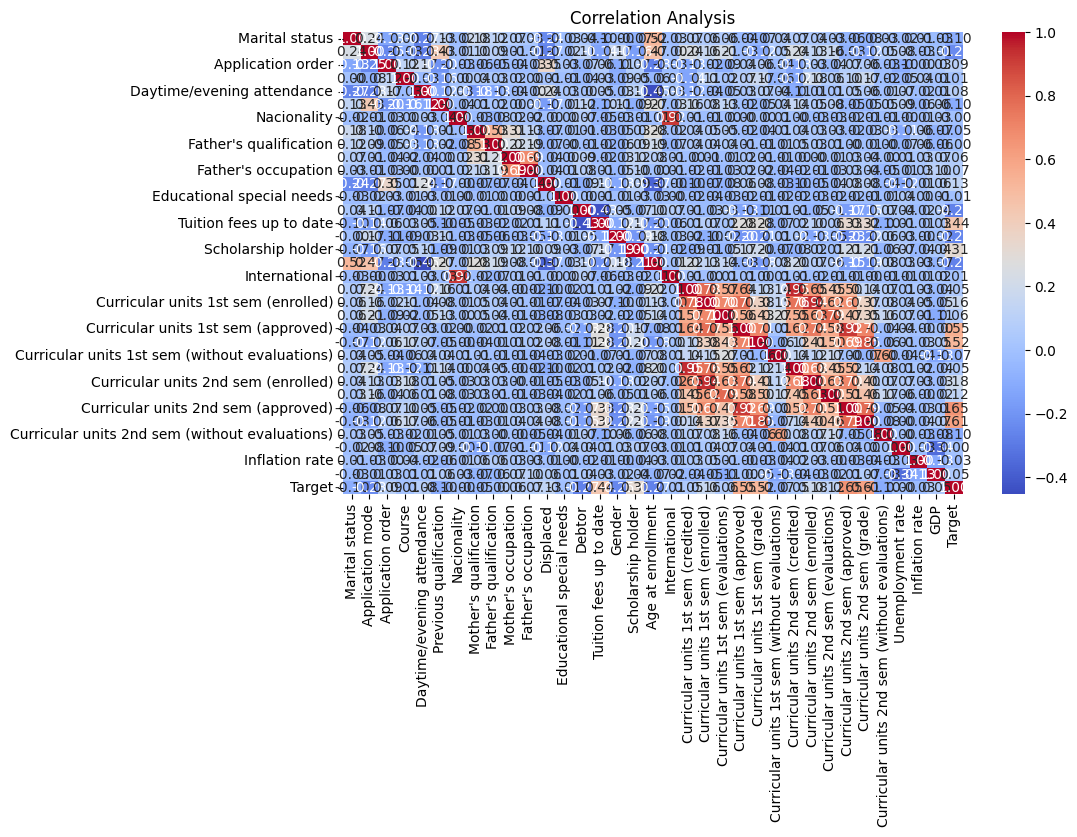

In [11]:
# correlation analysis
corr = df.corr()
plt.figure(figsize= (10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Analysis")
plt.show()

In [12]:
# setting feature and target
x = df.drop(columns= ['Target'])
y = df['Target']
non_numeric_columns.remove('Target')

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_exclude=['object'])),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), make_column_selector(dtype_include=['object']))
])

# split dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

# data preprocessing
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.fit_transform(x_test)

In [13]:
# model details
model_dict = {
    'logistic regression': LogisticRegression(max_iter= 1000),
    'ridge': RidgeClassifier(max_iter= 1000),
    'decision tree': DecisionTreeClassifier(random_state= 42),
    'random forest': RandomForestClassifier(random_state= 42),
    'AdaBoost': AdaBoostClassifier(algorithm= 'SAMME', random_state= 42),
    'gradient boosting': GradientBoostingClassifier(random_state= 42),
    'XGBoost': XGBClassifier(use_label_encoder= False, eval_matrics= 'logloss'),
    'lightgbm': LGBMClassifier(),
    'catboost': CatBoostClassifier(),
    'SVC': SVC(probability= True),
    'linear SVC': LinearSVC(random_state= 42),
}

# hyperparameter details
search_space = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'iterations': [500, 1000, 1500, 2000],
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'max_iter': [1000, 2000],
    'n_estimator': [0, 50, 100, 150],
    'max_depth': [None, 5, 10, 15, 20],
    'border_count': [50, 100, 150, 200],
    'num_leaves': [50, 00, 50, 200],
    'l2_leaf_reg': [1, 5, 10],
    'depth': [None, 5, 10, 15, 20],
    'learning_rate': [0.1, 0.5, 1],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20],
    'max_leaf_nodes': [5, 10, 15, 20],
    'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
}
catboost_search_space = {
    'learning_rate': [0.08, 0.085, 0.09],
    'iterations': [1000],
    'depth': [4, 6, 8], 
}

# filter hyperparameter
def filter_hyperparameter(model, space):
    if isinstance(model, CatBoostClassifier):
        return catboost_search_space
    valid_key = model.get_params()
    param_grid = {k:v for k,v in space.items() if k in valid_key}
    return param_grid

In [14]:
# model training with grid search
result = []
i = 0
for name, model in model_dict.items():
    print(f'Tuning for {name}')
    param_grid = filter_hyperparameter(model, search_space)
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted'),
    }
    grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 5, scoring= scoring, refit= 'accuracy', n_jobs= -1)
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    y_predict = best_model.predict(x_test)
    report = classification_report(y_test, y_predict, output_dict= True)
    conf = confusion_matrix(y_test, y_predict)
    result.append({
        'model_name': name,
        'best_parameter': grid.best_params_,
        'accuracy': round(accuracy_score(y_test, y_predict), 4),
        'F1_score': round(report['weighted avg']['f1-score'], 4),
        'precision': round(report['weighted avg']['precision'], 4),
        'recall': round(report['weighted avg']['recall'], 4),
    })
    i+=1
print('model tuning completed')

Tuning for logistic regression
Tuning for ridge
Tuning for decision tree
Tuning for random forest
Tuning for AdaBoost
Tuning for gradient boosting
Tuning for XGBoost
Tuning for lightgbm
[LightGBM] [Info] Number of positive: 1760, number of negative: 1144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 966
[LightGBM] [Info] Number of data points in the train set: 2904, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.606061 -> initscore=0.430783
[LightGBM] [Info] Start training from score 0.430783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [15]:
# finding best model
model_df = pd.DataFrame(result)
model_df

,model_name,best_parameter,accuracy,F1_score,precision,recall
0,logistic regression,"{'C': 1, 'max_iter': 1000}",0.9077,0.9073,0.9074,0.9077
1,ridge,"{'alpha': 0.1, 'max_iter': 1000}",0.9174,0.9160,0.9202,0.9174
2,decision tree,"{'max_depth': None, 'max_leaf_nodes': 10, 'min...",0.8802,0.8786,0.8806,0.8802
3,random forest,"{'max_depth': None, 'max_leaf_nodes': 20, 'min...",0.8939,0.8931,0.8938,0.8939
4,AdaBoost,{'learning_rate': 1},0.9063,0.9052,0.9074,0.9063
5,gradient boosting,"{'learning_rate': 0.1, 'max_depth': None, 'max...",0.9050,0.9042,0.9050,0.9050
6,XGBoost,"{'learning_rate': 0.1, 'max_depth': None}",0.5854,0.5581,0.7779,0.5854
7,lightgbm,"{'boosting_type': 'gbdt', 'learning_rate': 0.5...",0.8967,0.8959,0.8965,0.8967
8,catboost,"{'depth': 8, 'iterations': 1000, 'learning_rat...",0.9077,0.9069,0.9080,0.9077
9,SVC,"{'C': 0.1, 'kernel': 'linear', 'max_iter': 2000}",0.9105,0.9089,0.9133,0.9105


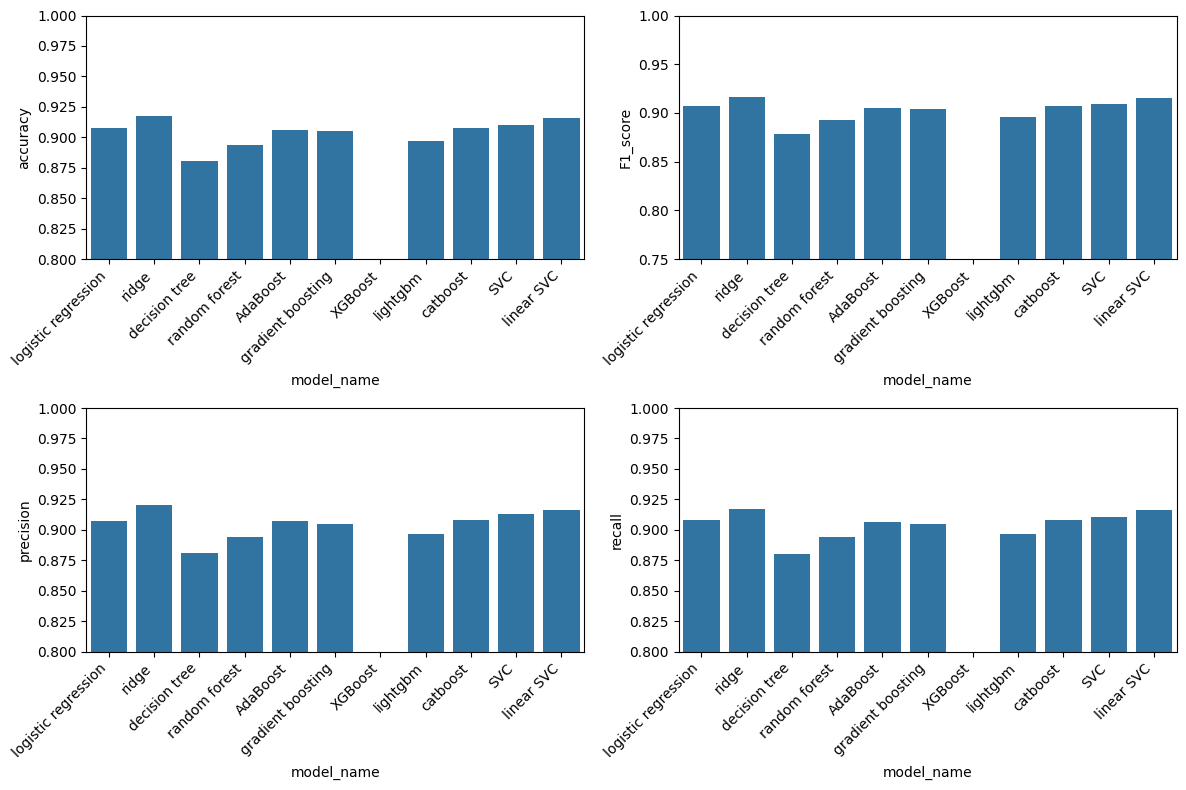

In [16]:
# ploting the netrics
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# accuracy
sns.barplot(x='model_name', y='accuracy', data=model_df, ax=ax[0][0])
ax[0][0].set_ylim(0.8, 1)
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=45, ha='right')

# F1-Score
sns.barplot(x='model_name', y='F1_score', data=model_df, ax=ax[0][1])
ax[0][1].set_ylim(0.75, 1)
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=45, ha='right')

# Precision
sns.barplot(x='model_name', y='precision', data=model_df, ax=ax[1][0])
ax[1][0].set_ylim(0.8, 1)
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=45, ha='right')

# Recall
sns.barplot(x='model_name', y='recall', data=model_df, ax=ax[1][1])
ax[1][1].set_ylim(0.8, 1)
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [17]:
# best model
model_df.sort_values(by= 'accuracy', ascending= False, inplace= True)
best_model = model_df.iloc[0]['model_name']
best_parameter = model_df.iloc[0]['best_parameter']
print("best model is:", best_model)
print("best parameter is:", best_parameter)

best model is: ridge
best parameter is: {'alpha': 0.1, 'max_iter': 1000}


In [18]:
# final model
final_model = model_dict[best_model].set_params(**best_parameter)

# final training and testing
final_model.fit(x_train, y_train)
y_predict = final_model.predict(x_test)

# model evaluation
accuracy = accuracy_score(y_test, y_predict)
conf = confusion_matrix(y_test, y_predict)
report = classification_report(y_test, y_predict)

print('best model: ',best_model)
print('accuracy score: ',accuracy)
print('\nconfusion matrix:\n',conf)
print('\nclassification report:\n',report)

best model:  ridge
accuracy score:  0.9173553719008265

confusion matrix:
 [[228  49]
 [ 11 438]]

classification report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88       277
           1       0.90      0.98      0.94       449

    accuracy                           0.92       726
   macro avg       0.93      0.90      0.91       726
weighted avg       0.92      0.92      0.92       726



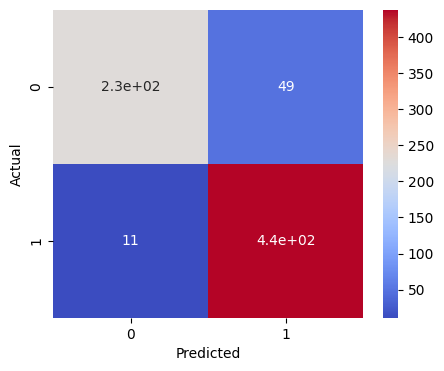

True Values: 666
Fake Values: 60


In [19]:
# visualizing confusion matrix
plt.figure(figsize= (5,4))
sns.heatmap(conf, annot= True, cmap= 'coolwarm', xticklabels= y.unique(), yticklabels= y.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(f'True Values: {conf[0][0] + conf[1][1]}')
print(f'Fake Values: {conf[1][0] + conf[0][1]}')

In [20]:
# retrain model
x = preprocessor.fit_transform(x)
final_model.fit(x, y)

# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', final_model)
])

# save model
model_name = "model.pkl"
with open(model_name, 'wb') as f:
    cloudpickle.dump(pipeline, f)
print(f'model saved as {model_name}')

model saved as model.pkl


In [21]:
# save everything
save_session()

Session saved to variables.session
